In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

### Load data

In [25]:
df = pd.read_parquet('/home/foolingeng/ruien/data/grab-posisi/trip_info/trip_info_sg.parquet')
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279768 entries, 0 to 279767
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   trj_id                279768 non-null  object        
 1   driving_mode          279768 non-null  object        
 2   osname                279768 non-null  object        
 3   start_time            279768 non-null  datetime64[ns]
 4   end_time              279768 non-null  datetime64[ns]
 5   eta                   279768 non-null  int64         
 6   start_lat             279768 non-null  float64       
 7   end_lat               279768 non-null  float64       
 8   start_lng             279768 non-null  float64       
 9   end_lng               279768 non-null  float64       
 10  time_of_day           279768 non-null  int64         
 11  day_of_week           279768 non-null  int64         
 12  avg_speed             279768 non-null  float64       
 13 

### Convert datetime data

In [107]:
df['start_hour'] = df['start_time'].dt.hour
df['start_minute'] = df['start_time'].dt.minute
df['end_hour'] = df['end_time'].dt.hour
df['end_minute'] = df['end_time'].dt.minute

array(['car'], dtype=object)

In [106]:
df.columns

Index(['trj_id', 'driving_mode', 'osname', 'start_time', 'end_time', 'eta',
       'start_lat', 'end_lat', 'start_lng', 'end_lng', 'time_of_day',
       'day_of_week', 'avg_speed', 'median_speed', 'distance',
       'crowded_cost_raw', 'col_cost_raw', 'school_cost_raw',
       'supermarket_cost_raw', 'mrt_cost_raw', 'parks_cost_raw',
       'hawker_cost_raw', 'mall_cost_raw', 'is_crowded', 'is_real_value',
       'is_near_school', 'is_near_supermarket', 'is_near_mrt', 'is_near_park',
       'is_near_hawker', 'is_near_mall', 'crowded_cost', 'col_cost',
       'school_cost', 'supermarket_cost', 'mrt_cost', 'park_cost',
       'hawker_cost', 'mall_cost', 'start_hour', 'start_minute', 'end_hour',
       'end_minute'],
      dtype='object')

### Split dataset

In [108]:
train_size = int(0.8 * df.shape[0])
df_train = df.loc[:train_size, :]
df_test = df.loc[train_size:, :]

train_features = [
    # 'driving_mode', 'start_time', 'end_time',
    'start_hour', 'start_minute',
    'start_lat', 'end_lat', 'start_lng', 'end_lng', 'time_of_day',
    'day_of_week', 'avg_speed', 'median_speed', 'distance',
    'crowded_cost_raw', 'col_cost_raw', 'school_cost_raw',
    'supermarket_cost_raw', 'mrt_cost_raw', 'parks_cost_raw',
    'hawker_cost_raw', 'mall_cost_raw', 'is_crowded', 'is_real_value',
    'is_near_school', 'is_near_supermarket', 'is_near_mrt', 'is_near_park',
    'is_near_hawker', 'is_near_mall', 'crowded_cost', 'col_cost',
    'school_cost', 'supermarket_cost', 'mrt_cost', 'park_cost',
    'hawker_cost', 'mall_cost']
target_feature = 'eta'

x_train = df_train[train_features]
y_train = df_train[target_feature]
x_test = df_test[train_features]
y_test = df_test[target_feature]

df_train.shape, df_test.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape

((223815, 43), (55954, 43), (223815, 35), (223815,), (55954, 35), (55954,))

### Preprocessing

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)

x_train_transformed = scaler.transform(x_train)
x_test_transformed = scaler.transform(x_test)
x_train_transformed.shape, x_test_transformed.shape
x_train_transformed

array([[ 0.34341833, -0.17137756, -1.05473169, ...,  1.12441929,
        -0.96472921,  2.86533847],
       [-1.10517752,  0.88172841, -0.12992906, ..., -0.42370002,
        -0.77365566,  0.77987407],
       [-1.42708771,  1.17425784,  1.8199718 , ..., -1.40237587,
        -0.9655104 , -1.24201194],
       ...,
       [ 2.11392437,  0.06264599, -0.33389543, ..., -0.09077033,
        -0.38828282, -0.32393725],
       [ 1.14819381, -0.40540111, -1.39840781, ...,  0.27122323,
        -0.92256623, -0.1153641 ],
       [-1.26613261,  0.53069308, -0.403023  , ..., -0.70756184,
        -0.10041229,  0.02532622]])

In [110]:
train_data = lgb.Dataset(x_train, label=x_test, categorical_feature=[''])

### Hyperparameter tuning

In [111]:
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [127, 255]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(x_train_transformed, y_train)

print(f'Best parameters found by grid search are: {gbm.best_params_}')

Best parameters found by grid search are: {'learning_rate': 0.3, 'n_estimators': 255}


### Train

In [113]:
gbm = lgb.LGBMRegressor(num_leaves=127,
                        learning_rate=0.3,
                        n_estimators=255,
                        reg_lambda=1e-3,
                        boosting_type='gbdt')

gbm.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(5)])

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's l2: 1.55856


LGBMRegressor(learning_rate=0.3, n_estimators=255, num_leaves=127,
              reg_lambda=0.001)

In [114]:
gbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 255,
 'n_jobs': -1,
 'num_leaves': 127,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.001,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Evaluation

In [115]:
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

# feature importances
print(f'Feature importances: {list(gbm.feature_importances_)}')

y_pred, y_test

The RMSE of prediction is: 1.2484217978053376
Feature importances: [1407, 1977, 2077, 1885, 2034, 1790, 0, 900, 1621, 1227, 2132, 521, 567, 450, 441, 533, 544, 473, 452, 849, 817, 816, 740, 861, 761, 781, 799, 570, 518, 550, 516, 605, 562, 711, 643]


(array([15.09876938, 18.80622294, 14.86620492, ..., 20.12313297,
        19.33278019, 13.95933756]),
 223814    16
 223815    18
 223816    16
 223817    13
 223818    20
           ..
 279763    19
 279764    29
 279765    20
 279766    18
 279767    15
 Name: eta, Length: 55954, dtype: int64)

<AxesSubplot:title={'center':'Split value histogram for feature with name distance'}, xlabel='Feature split value', ylabel='Count'>

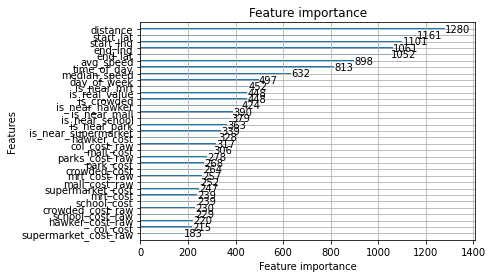

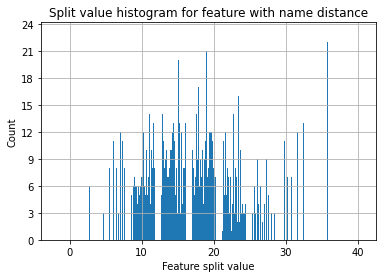

In [88]:
lgb.plot_importance(gbm)
lgb.plot_split_value_histogram(gbm, 'distance')